In [5]:
import pandas as pd
from contextlib import chdir
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

In [6]:
with chdir(".."):
    not_matched_df = pd.read_csv("results/not_matched.csv")

In [7]:
not_matched_df.head()

,Unnamed: 0,chrom,position,gene,type
0,0,chr1,1615495.0,MIB2,Missense_Mutation
1,1,chr1,1615507.0,MIB2,Missense_Mutation
2,2,chr1,1615507.0,MIB2,Missense_Mutation
3,3,chr1,2586800.0,PRXL2B,Silent
4,4,chr1,2586800.0,PRXL2B,Silent


In [8]:
category_counts = not_matched_df.groupby('gene').size().reset_index(name='Count').sort_values(by='Count', ascending=False)
category_counts

,gene,Count
325,MUC2,723
390,OR5D13,307
395,OR5L1,298
375,OR4C16,294
370,OR2L8,281
...,...,...
335,NFKBIE,1
340,NLN,1
343,NSG2,1
344,NTHL1,1


In [9]:
with chdir(".."):
    ccds_df = pd.read_csv("ref_data/raw/CCDS.current.txt", sep="\t")

columns_to_keep = ['gene', 'ccds_status']
ccds_df = ccds_df[columns_to_keep]
ccds_df.head()

,gene,ccds_status
0,LINC00115,Withdrawn
1,SAMD11,Public
2,NOC2L,Public
3,PLEKHN1,Public
4,HES4,Public


In [10]:
merged_df = pd.merge(category_counts, ccds_df, on='gene', how='left')
merged_df

,gene,Count,ccds_status
0,MUC2,723,NaN
1,OR5D13,307,Withdrawn
2,OR5L1,298,Withdrawn
3,OR4C16,294,Withdrawn
4,OR2L8,281,Withdrawn
...,...,...,...
1046,NSG2,1,Public
1047,NTHL1,1,Public
1048,ZSCAN32,1,Public
1049,ZSCAN32,1,Public


In [11]:
merged_df = merged_df.sort_values(by=['Count', 'gene', 'ccds_status'], ascending=[False, True, False])
merged_df

,gene,Count,ccds_status
0,MUC2,723,NaN
1,OR5D13,307,Withdrawn
2,OR5L1,298,Withdrawn
3,OR4C16,294,Withdrawn
4,OR2L8,281,Withdrawn
...,...,...,...
809,ZNF646,1,Public
815,ZNF852,1,NaN
1048,ZSCAN32,1,Public
1049,ZSCAN32,1,Public


In [12]:
final_df = merged_df.drop_duplicates(subset=['gene'], keep='first')
final_df = final_df.fillna('Missing from CCDS')

In [13]:
with chdir(".."):
    final_df.to_csv('results/not_matched_ccds.csv')

In [14]:
final_df

,gene,Count,ccds_status
0,MUC2,723,Missing from CCDS
1,OR5D13,307,Withdrawn
2,OR5L1,298,Withdrawn
3,OR4C16,294,Withdrawn
4,OR2L8,281,Withdrawn
...,...,...,...
813,ZNF208,1,Public
810,ZNF511,1,Public
809,ZNF646,1,Public
815,ZNF852,1,Missing from CCDS


Text(0.5, 1.0, 'Top 50 most common genes that contain mutations not matched to CCDS, colored by CCDS Status')

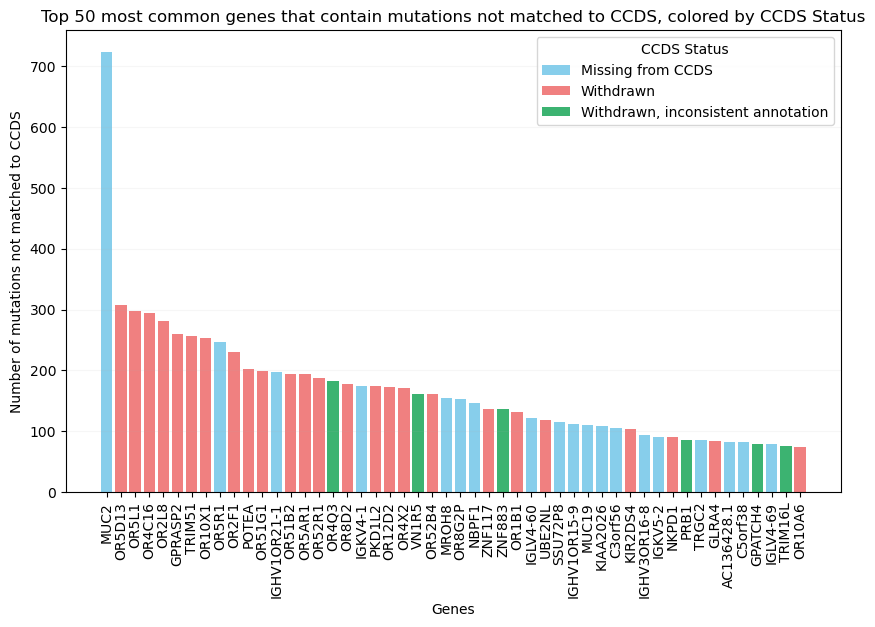

In [15]:


bar_colors = ['skyblue' if ccds_status == 'Missing from CCDS'
           else 'lightcoral' if ccds_status == 'Withdrawn'
           else 'mediumseagreen' if ccds_status == 'Withdrawn, inconsistent annotation'
           else 'black'
           for ccds_status in final_df['ccds_status']]

genes_to_keep = 50

plt.figure(figsize=(10, 6))


plt.bar(final_df['gene'][:genes_to_keep], final_df['Count'][:genes_to_keep], color=bar_colors[:genes_to_keep])

legend_handles = [
        Patch(facecolor='skyblue', label='Missing from CCDS'),
        Patch(facecolor='lightcoral', label='Withdrawn'),
        Patch(facecolor='mediumseagreen', label='Withdrawn, inconsistent annotation')
    ]

plt.legend(handles=legend_handles, title='CCDS Status')
plt.grid(axis='y', alpha=0.1)
plt.xlabel('Genes')
plt.xticks(rotation=90)
plt.ylabel('Number of mutations not matched to CCDS')
plt.title('Top 50 most common genes that contain mutations not matched to CCDS, colored by CCDS Status')

In [16]:
status_counts_df = final_df.groupby('ccds_status')['Count'].sum().reset_index(name='Count').sort_values(by='Count', ascending=False)
status_counts_df

,ccds_status,Count
5,Withdrawn,6128
0,Missing from CCDS,4662
1,Public,1430
6,"Withdrawn, inconsistent annotation",1046
3,"Under review, update",63
2,"Reviewed, update pending",27
4,"Under review, withdrawal",1


Calculate the percentage of non matched mutations that are due to CCDS issues vs those that are outside proper CCDS ranges

In [31]:
CCDS_issue_statuses = ['Withdrawn', 'Missing from CCDS', 'Withdrawn, inconsistent annotation']
other_statuses = ['Public', 'Under review, update', 'Reviewed, update pending', 'Under review, withdrawal']

n_CCDS_issue = status_counts_df[status_counts_df['ccds_status'].isin(CCDS_issue_statuses)].sum().iloc[1]
n_other = status_counts_df[status_counts_df['ccds_status'].isin(other_statuses)].sum().iloc[1]

In [35]:
pct = n_CCDS_issue / (n_CCDS_issue + n_other)
print(f"Percentage of non-matched mutations that are from withdrawn or not available CCDS genes: {round(pct*100, 2)}%")

Percentage of non-matched mutations that are from withdrawn or not available CCDS genes: 88.61%
